## Theano Tutorial
__source__ : http://www.marekrei.com/blog/theano-tutorial/

In [1]:
%pylab inline
import theano as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

### Important!
When we are creating a model with Theano, we first define a symbolic graph of all variables and operations that need to be performed. And then we can apply this graph on specific inputs to get outputs.

For example, what do you think happens when this line of Theano code is executed in our script?

1
y = (x * W).sum()
The system takes x and W, multiplies them together and sums the values. Right?

NOPE

Instead, we create a Theano object y that knows its values can be calculated as the dot-product of x and W. But the required mathematical operations are not performed here. In fact, when this line was executed in our example code above, x didn’t even have a value yet.


In [3]:
## Theano Tensor Variable
x = T.tensor.vector('x',dtype='float32')

In [4]:
## Theano Shared Variable
'''
We can also define shared variables, which are shared between different functions and different function calls. 
Normally, these would be used for weights in our neural network. Theano will automatically try to move shared 
variables to the GPU, provided one is available, in order to speed up computation.
'''
W = T.shared(np.asarray([2.0,7.0]),name='W')

In [5]:
## Operation for Theano Variables (Not actually done!)
y = (x*W).sum()

In [6]:
## Theano function
'''
Theano functions are basically hooks for interacting with the symbolic graph. 
Commonly, we use them for passing input into our network and collecting the resulting output.
'''
f = T.function([x],y)

In [7]:
## Using Theano Function to calculate the value
## The function uses all of the required Theano variables by itself
output = f([1.0,2.0])

In [8]:
print output

16.0


In [9]:
target = T.tensor.fscalar('target')

In [10]:
cost = T.tensor.sqr(target-y)

In [11]:
gradients = T.tensor.grad(cost,[W])

In [12]:
W_updated = W - (0.1 * gradients[0])
updates = [(W,W_updated)]

In [13]:
f = T.function([x, target], y, updates=updates)

In [14]:
for i in xrange(10):
    output = f([1.0, 1.0], 20.0)
    print output

9.0
13.4
16.04
17.624
18.5744
19.14464
19.486784
19.6920704
19.81524224
19.889145344


In [16]:
W.eval()

array([  7.4667436,  12.4667436])

## Implementing a Neural Network Using Theano

In [17]:
def plot_decision_boundary(X,y):
    
    '''
        Plotting the decision boundary of 
        a classification dataset. The function
        takes in a trained model and corresponding
        data points
    '''
    h = 0.0025
    #X - some data in 2dimensional np.array
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # here "model" is your model's prediction (classification) function
    Z = prediction(np.c_[xx.ravel(), yy.ravel()]) 
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.axis('off')
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [18]:
from sklearn.datasets import make_moons
train,label = make_moons(n_samples=200,noise=0.20)
print train.shape
print label.shape

(200, 2)
(200,)


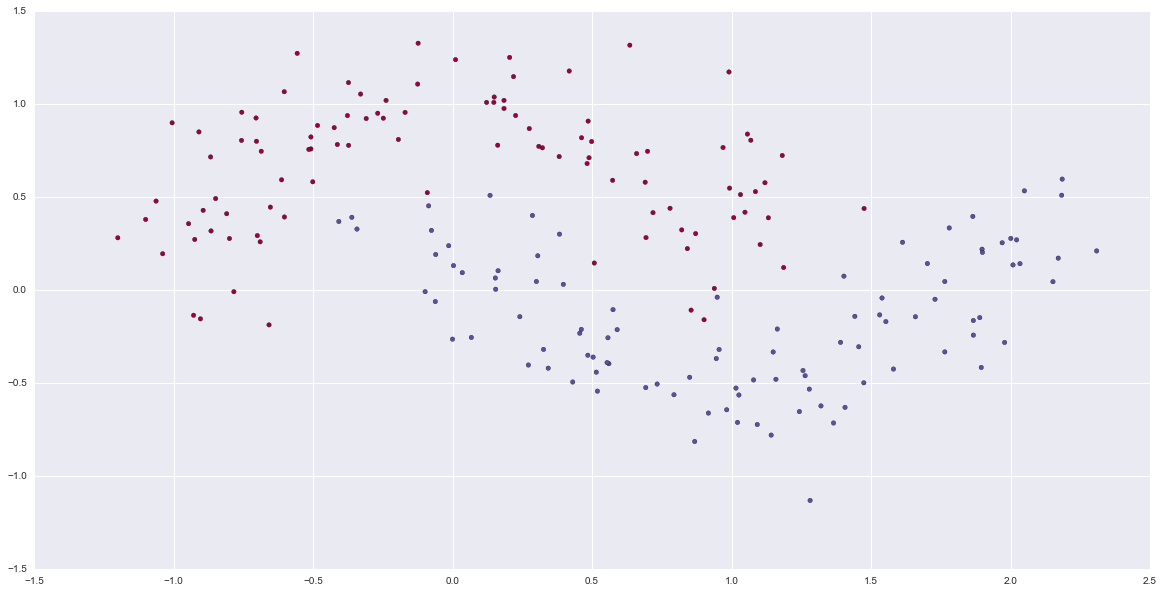

In [19]:
plt.scatter(train[:,0],train[:,1],c=label,cmap=plt.cm.Spectral)

In [20]:
nn_input_layer = 2
nn_hidden_layer = 4
nn_output_layer = 2
n_samples = 200
lamda = 0.01
alpha = 0.01

In [23]:
## Declaring the variables and Parameters
X = T.tensor.matrix('X')
y = T.tensor.lvector('y')
W1 = T.shared(np.random.randn(nn_input_layer,nn_hidden_layer),name='W1')
W2 = T.shared(np.random.randn(nn_hidden_layer,nn_output_layer),name='W2')
b1 = T.shared(np.zeros(nn_hidden_layer),name='b1')
b2 = T.shared(np.zeros(nn_output_layer),name='b2')

In [24]:
## Implementing the forward pass
z1 = X.dot(W1) + b1
a1 = T.tensor.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.tensor.nnet.softmax(z2)

In [25]:
## Calculating the regularization term
reg = (lamda/(2*n_samples))*(T.tensor.sum(T.tensor.sqr(W1)) + T.tensor.sum(T.tensor.sqr(W2)))
## Calculating the loss (including the regularization)
loss = T.tensor.nnet.categorical_crossentropy(y_hat,y).mean() + reg
## Calculating the class based on Bayes Rule
preds = T.tensor.argmax(y_hat,axis=1)

In [26]:
## Functions for returning the loss and predictions
prediction = T.function([X],preds)
cost_function = T.function([X,y],loss)

In [27]:
## Computing the backpropagation
dW1 = T.tensor.grad(loss,W1)
dW2 = T.tensor.grad(loss,W2)
db1 = T.tensor.grad(loss,b1)
db2 = T.tensor.grad(loss,b2)

In [28]:
gradient = T.function([X,y],updates=((W2,W2 - alpha*dW2),(W1,W1 - alpha*dW1),\
                                       (b2,b2 - alpha*db2),(b1,b1 - alpha*db1)))

In [29]:
def build_model(num_passes=2000,print_loss=False):
    
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_layer, nn_hidden_layer) / np.sqrt(nn_input_layer))
    b1.set_value(np.zeros(nn_hidden_layer))
    W2.set_value(np.random.randn(nn_hidden_layer, nn_output_layer) / np.sqrt(nn_hidden_layer))
    b2.set_value(np.zeros(nn_output_layer))
    
    for i in xrange(1,num_passes+1):
        
        gradient(train,label)
        if i % 1000 == 0 and print_loss:
            print 'After {} iterations, Loss is {}'.format(i,cost_function(train,label))

In [31]:
build_model(num_passes=20000,print_loss=True)

After 1000 iterations, Loss is 0.309607595876
After 2000 iterations, Loss is 0.27828405294
After 3000 iterations, Loss is 0.268337699794
After 4000 iterations, Loss is 0.260956199872
After 5000 iterations, Loss is 0.252504123066
After 6000 iterations, Loss is 0.241796547273
After 7000 iterations, Loss is 0.228655910406
After 8000 iterations, Loss is 0.213760519541
After 9000 iterations, Loss is 0.198164970215
After 10000 iterations, Loss is 0.182714477559
After 11000 iterations, Loss is 0.167873153099
After 12000 iterations, Loss is 0.153876376957
After 13000 iterations, Loss is 0.140910997143
After 14000 iterations, Loss is 0.129183312141
After 15000 iterations, Loss is 0.118868448806
After 16000 iterations, Loss is 0.110030593906
After 17000 iterations, Loss is 0.102602976251
After 18000 iterations, Loss is 0.0964291853402
After 19000 iterations, Loss is 0.091318392584
After 20000 iterations, Loss is 0.0870838883987


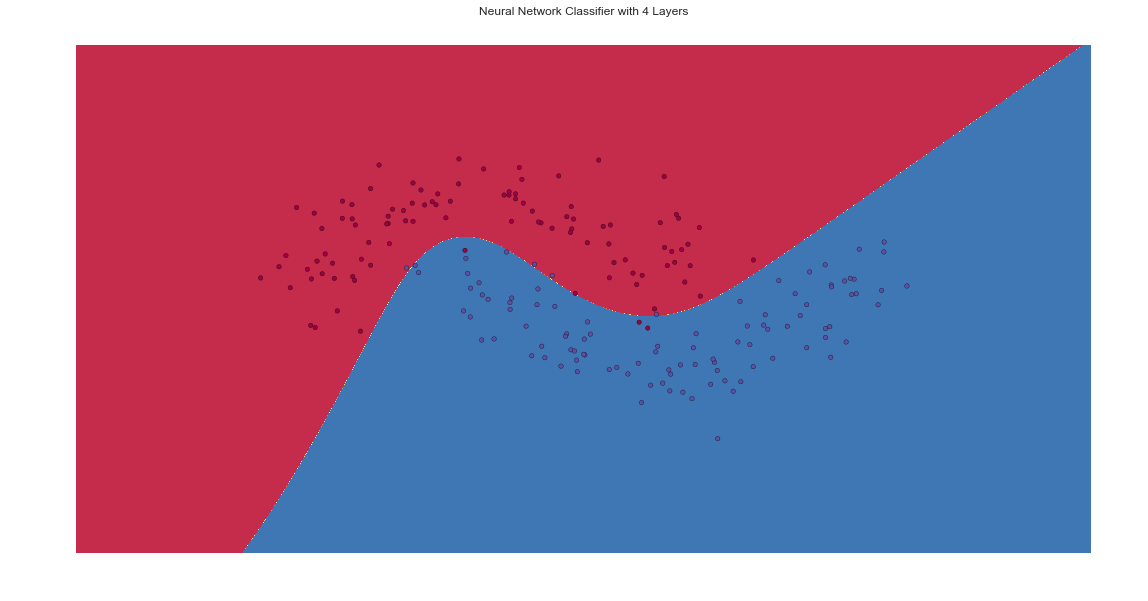

In [33]:
plot_decision_boundary(train,label)
plt.title('Neural Network Classifier with 4 Layers')